<a href="https://colab.research.google.com/github/sreeja2208/assignments/blob/main/Lab12Pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation Engine

## Clustering based recommendation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
#importing movie datasets
movies=pd.read_csv('ml-latest-small/movies.csv')
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [3]:
ratings=pd.read_csv('ml-latest-small/ratings.csv')
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [4]:
#total number of ratings for toatal number of movies
print('the dataset contains ',len(ratings),'for ',len(movies))

the dataset contains  100836 for  9742


### Romance versus Science Fiction

We will start by considering a subset of users and discovering what are their favourite genre. We will do this by defining a function that will calculate each user’s average rating for all science fiction and romance movies.

In [5]:
#function to get the genre 
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
print(genre_ratings.head())
print(genre_ratings.shape)

   avg_romance_rating  avg_scifi_rating
1                4.31              4.22
2                4.50              3.88
3                0.50              4.20
4                3.38              2.83
5                3.09              2.50
(610, 2)


In order to have a more delimited subset of people to study, we are going to bias our grouping to only get ratings from those users that like either romance or science fiction movies.

In [6]:
#function to get biased dataset
def bias_genre_rating_dataset(genre_ratings,score_limit_1,score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

In [7]:
biased_dataset=bias_genre_rating_dataset(genre_ratings,3.2,2.5)

In [8]:
print('number of users:',len(biased_dataset))
biased_dataset.head(10)

number of users: 162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00
5,10,3.33,2.00
6,19,2.68,2.56
7,26,3.00,2.00
8,28,2.89,3.18
9,35,3.56,3.00


In [9]:
def draw_scatterplot(x_data,x_label,y_data,y_label):
  fig=plt.figure(figsize=(8,8))
  ax=fig.add_subplot(111)
  plt.xlim(0,5)
  plt.ylim(0,5)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  ax.scatter(x_data,y_data,s=30)

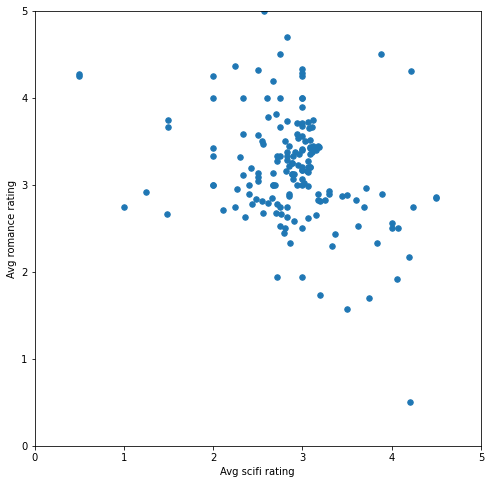

In [10]:
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

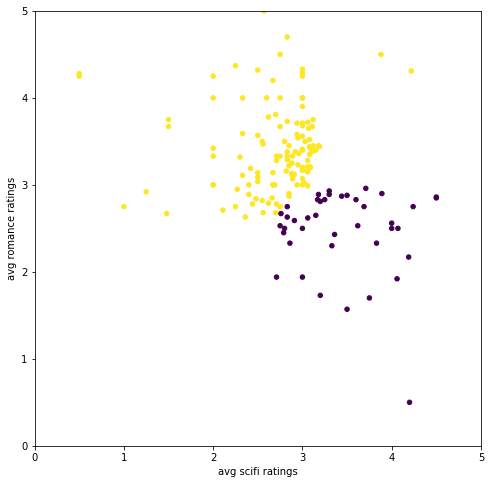

In [11]:
#dataset to list
x=biased_dataset[['avg_scifi_rating','avg_romance_rating']].values

#import Kmeans from sklearn
from sklearn.cluster import KMeans

kmeans_1=KMeans(n_clusters=2)
predictions=kmeans_1.fit_predict(x)

def draw_clusters(biased_dataset,predictions,cmap='viridis'):
  fig=plt.figure(figsize=(8,8))
  ax=fig.add_subplot(111)
  plt.xlim(0,5)
  plt.ylim(0,5)
  ax.set_xlabel('avg scifi ratings')
  ax.set_ylabel('avg romance ratings')
  clustered=pd.concat([biased_dataset.reset_index(),pd.DataFrame({'group':predictions})],axis=1)
  plt.scatter(clustered['avg_scifi_rating'],clustered['avg_romance_rating'],c=clustered['group'],s=20,cmap=cmap)

draw_clusters(biased_dataset,predictions)  

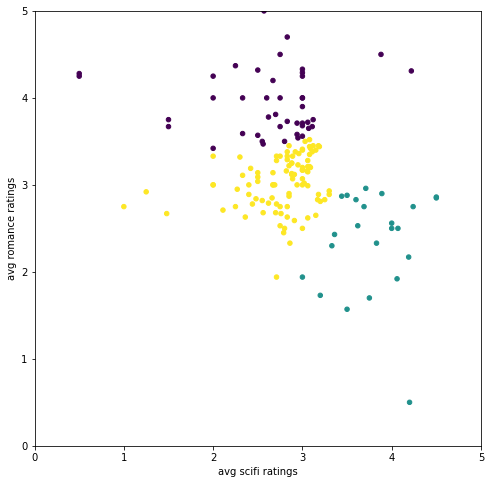

In [12]:
kmeans_2=KMeans(n_clusters=3)
predictions_2=kmeans_2.fit_predict(x)
draw_clusters(biased_dataset,predictions_2)

In [13]:
#people who like both scifi and romance moderately -green
#people who like scifi more -yellow
#people who like romance more -purple

Finding optimal clusters using silhouette score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  """


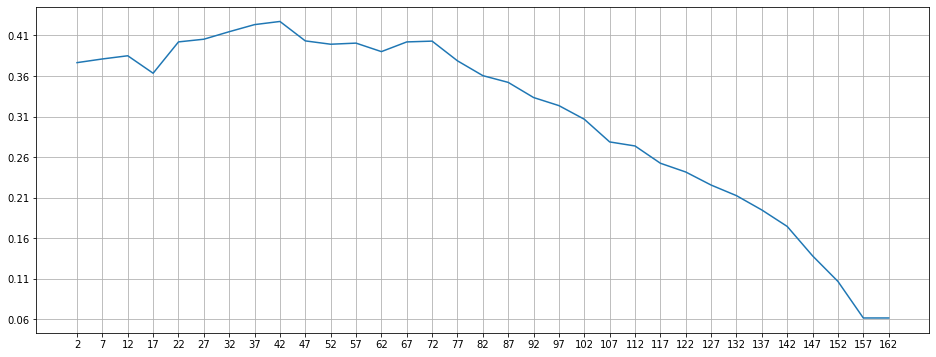

In [14]:
df=biased_dataset[['avg_scifi_rating','avg_romance_rating']]
possible_k_values=range(2,len(x)+1,5)

def clustering_errors(k,data):
  kmeans=KMeans(n_clusters=k).fit(data)
  predictions=kmeans.predict(data)
  #cluster_center=kmeans.cluster_centers_
  #errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
  #return sum(errors)
  silhouette_avg = silhouette_score(data, predictions)
  return silhouette_avg

errors_per_k =[clustering_errors(k,x) for k in possible_k_values] 
fig,ax=plt.subplots(figsize=(16,6))
plt.plot(possible_k_values,errors_per_k)

#ticks and grid
xticks=np.arange(min(possible_k_values),max(possible_k_values)+1,5.0)
ax.set_xticks(xticks,minor=False)
ax.set_xticks(xticks,minor=True)
ax.xaxis.grid(True,which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

We will chose the K = 7 as it is the one that yields the best score and will be easier to visualize.



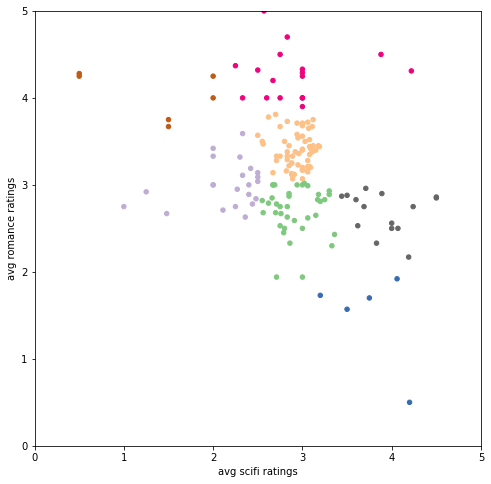

In [15]:
kmeans_4=KMeans(n_clusters=7)
predictions_4=kmeans_4.fit_predict(x)
draw_clusters(biased_dataset,predictions_4,cmap='Accent')

Up to now, we have only analyzed romance and science-fiction movies. Let us see what happens when adding other genre to our analysis by adding Action movies.

In [16]:
biased_dataset_3_genres=get_genre_ratings(ratings,movies,['Romance','Sci-Fi','Action'],['avg_romance_rating','avg_scifi_rating','avg_action_rating'])
biased_dataset_3_genres=bias_genre_rating_dataset(biased_dataset_3_genres,3.2,2.5).dropna()
print('number of users left after biased filtering are',len(biased_dataset_3_genres))
biased_dataset_3_genres.head(10)

number of users left after biased filtering are 161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12
5,10,3.33,2.00,3.50
6,19,2.68,2.56,2.73
7,26,3.00,2.00,3.00
8,28,2.89,3.18,3.06
9,35,3.56,3.00,4.00


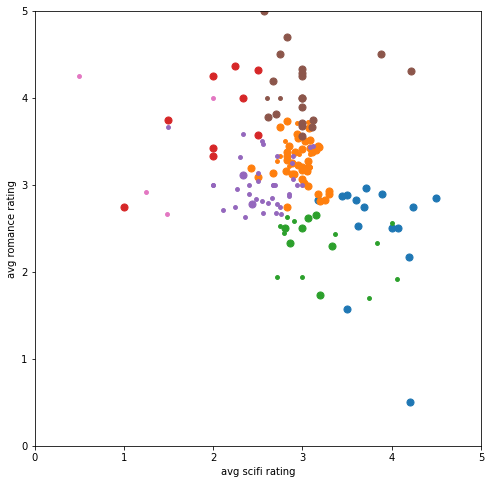

In [17]:
x_with_action=biased_dataset_3_genres[['avg_romance_rating','avg_scifi_rating','avg_action_rating']].values
kmeans_5=KMeans(n_clusters=7)
predictions_5=kmeans_5.fit_predict(x_with_action)
def draw_clusters_3d(biased_dataset_3,predictions):
  fig=plt.figure(figsize=(8,8))
  ax=fig.add_subplot(111)
  plt.xlim(0,5)
  plt.ylim(0,5)
  ax.set_xlabel('avg scifi rating')
  ax.set_ylabel('avg romance rating')
  clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
  colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
  for g in clustered.group.unique():
      color = next(colors)
      for index, point in clustered[clustered.group == g].iterrows():
          if point['avg_action_rating'].astype(float) > 3: 
              size = 50
          else:
              size = 15
          plt.scatter(point['avg_scifi_rating'], 
                      point['avg_romance_rating'], 
                      s=size, 
                      color=color)
draw_clusters_3d(biased_dataset_3_genres, predictions_5)
#size of dots represent the data of action movies

### Taking users into consideration

Once we have seen and understood how the K-Means algorithm group the users by their movie genre preferences, we are going to take a bigger picture of the dataset and explore how users rate individual movies.

To do so, we will subset the dataset by ‘userid’ vs ‘user rating’ as follows.

In [18]:
#merging two tables and then pivot to make users X movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#function to get most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

#function to get which users rate movies the most
def get_users_who_rate_the_most(most_rated_movies, n_users):
    most_rated_movies['num_ratings'] = - most_rated_movies.isnull().sum(axis=1)
    most_rated_movies = most_rated_movies.sort_values(by=['num_ratings'], ascending=False)
    most_rated_movies = most_rated_movies.iloc[:n_users, :]
    most_rated_movies = most_rated_movies.drop('num_ratings', axis=1)
    return most_rated_movies

 #sorting by rating function
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

n_movies=30
n_users=18
most_rated_movies_users_selection=sort_by_rating_density(user_movie_ratings,n_movies,n_users)
print('dataset dimensions: ', most_rated_movies_users_selection.shape)
print(most_rated_movies_users_selection.head())

dataset dimensions:  (18, 30)
title  Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
413                    5.0                               5.0   
589                    5.0                               4.5   
473                    3.0                               5.0   
479                    5.0                               5.0   
67                     3.5                               3.0   

title  Pulp Fiction (1994)  Silence of the Lambs, The (1991)  \
413                    5.0                               4.0   
589                    4.5                               3.5   
473                    4.0                               4.5   
479                    4.0                               4.5   
67                     2.0                               3.5   

title  Matrix, The (1999)  Star Wars: Episode IV - A New Hope (1977)  \
413                   5.0                                        5.0   
589                   4.0                               

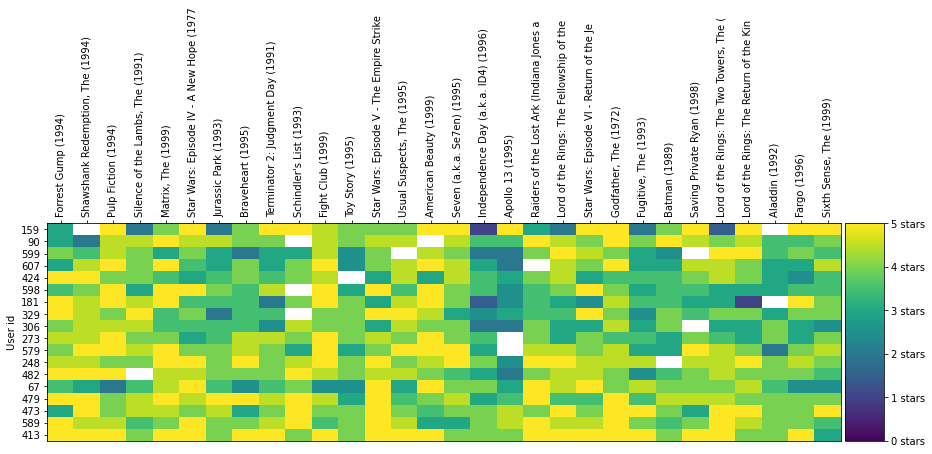

In [20]:
#plotting heatmap function
def draw_movies_heatmap(most_rated_movies_users_selection,axis_labels=True):
  fig=plt.figure(figsize=(15,4))
  ax=plt.gca()

  heatmap=ax.imshow(most_rated_movies_users_selection,interpolation='nearest',vmin=0,vmax=5,aspect='auto')
  if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
  else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
  ax.grid(False)
  ax.set_ylabel('User id')# Separate heatmap from color bar
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)# Color bar
  cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
  cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
  plt.show()# Print the heatmap
draw_movies_heatmap(most_rated_movies_users_selection)

In [21]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000).replace(np.nan, 0)

In [22]:
from scipy import sparse
sparse_ratings = sparse.csr_matrix(most_rated_movies_1k.values)

In [23]:
#large scale clustering
#20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
clustered = pd.concat([get_most_rated_movies(user_movie_ratings, 1000).reset_index(), pd.DataFrame({'group':predictions})], axis=1)

### Predictions and Recommendation 

     Forrest Gump (1994)  Shawshank Redemption, The (1994)  \
4                    NaN                               3.0   
7                    3.0                               5.0   
10                   5.0                               4.0   
13                   4.0                               3.0   
25                   3.0                               NaN   
32                   5.0                               4.0   
34                   NaN                               NaN   
36                   4.0                               4.0   
45                   NaN                               4.0   
53                   4.0                               4.0   
55                   5.0                               4.0   
80                   2.0                               3.0   
92                   5.0                               4.0   
93                   3.0                               5.0   
98                   NaN                               5.0   
101     

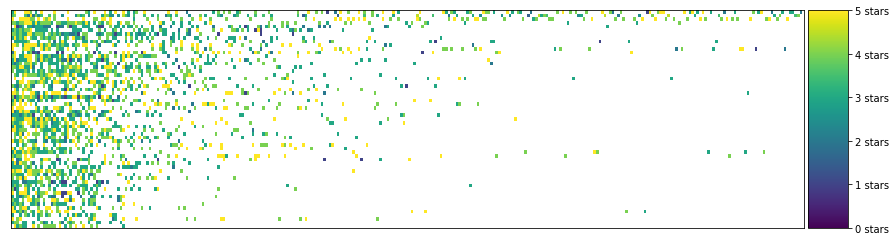

In [24]:
cluster_number = 11
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
print(cluster)
cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [25]:
movie_name='Matrix, The (1999)'
cluster[movie_name].mean()

4.0

In [26]:
cluster.mean().head(20)

Apollo 13 (1995)                     3.928571
Pulp Fiction (1994)                  3.936170
Batman (1989)                        3.085106
Dances with Wolves (1990)            3.955556
True Lies (1994)                     3.622222
Forrest Gump (1994)                  4.220930
Braveheart (1995)                    4.166667
Shawshank Redemption, The (1994)     4.292683
Batman Forever (1995)                3.146341
Crimson Tide (1995)                  3.763158
Stargate (1994)                      3.065789
Fugitive, The (1993)                 4.144737
Cliffhanger (1993)                   3.405405
Clear and Present Danger (1994)      3.675676
Jurassic Park (1993)                 3.736111
Ace Ventura: Pet Detective (1994)    3.111111
Aladdin (1992)                       3.583333
Outbreak (1995)                      3.485714
Die Hard: With a Vengeance (1995)    3.628571
Waterworld (1995)                    2.808824
dtype: float64

In [27]:
cluster

,Apollo 13 (1995),Pulp Fiction (1994),Batman (1989),Dances with Wolves (1990),True Lies (1994),Forrest Gump (1994),Braveheart (1995),"Shawshank Redemption, The (1994)",Batman Forever (1995),Crimson Tide (1995),...,"Crying Game, The (1992)",Runaway Bride (1999),Lethal Weapon 3 (1992),Groundhog Day (1993),Fried Green Tomatoes (1991),"Negotiator, The (1998)",Interstellar (2014),"Nightmare Before Christmas, The (1993)",October Sky (1999),"Hobbit: An Unexpected Journey, The (2012)"
5,3.0,5.0,NaN,NaN,NaN,5.0,5.0,4.0,NaN,3.0,...,NaN,3.0,NaN,NaN,3.0,3.0,NaN,NaN,2.0,NaN
33,3.5,4.0,NaN,NaN,NaN,3.5,2.0,5.0,2.0,4.0,...,4.0,NaN,NaN,NaN,NaN,NaN,3.5,4.0,NaN,NaN
12,5.0,NaN,NaN,5.0,5.0,5.0,5.0,4.0,4.0,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
28,4.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,NaN,5.0,1.0,2.0,3.0,NaN,3.0,3.0,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,3.0,4.0,3.0,4.0,3.0,4.0,4.0,5.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,4.0,4.0,3.0,4.0,3.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,3.0,5.0,3.0,4.0,3.0,5.0,NaN,4.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaN,3.0,3.0,3.0,3.0,3.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,5.0,5.0,4.0,NaN,3.0,5.0,5.0,5.0,5.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
user_id = 12
# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
# Which movies did they not rate? 
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Swingers (1996)                                            5.000000
Wizard of Oz, The (1939)                                   5.000000
My Fair Lady (1964)                                        5.000000
Femme Nikita, La (Nikita) (1990)                           5.000000
Boogie Nights (1997)                                       5.000000
Army of Darkness (1993)                                    5.000000
Space Jam (1996)                                           5.000000
Go (1999)                                                  5.000000
Emma (1996)                                                5.000000
Wallace & Gromit: The Best of Aardman Animation (1996)     5.000000
Contact (1997)                                             5.000000
Top Gun (1986)                                             5.000000
L.A. Confidential (1997)                                   5.000000
Gattaca (1997)                                             5.000000
Billy Madison (1995)                            

## Using Collaborative Filtering (With fast.ai)

In [29]:
! [ -e /content ] && pip install -Uqq fastai

In [30]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

For this, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [31]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [32]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [33]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [34]:
ratings=ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [35]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [36]:
dls.show_batch()

,user,title,rating
0,49,Stargate (1994),2
1,429,My Fair Lady (1964),3
2,227,Beavis and Butt-head Do America (1996),1
3,480,Star Wars (1977),4
4,29,Spawn (1997),2
5,250,Star Wars (1977),5
6,267,Demolition Man (1993),3
7,295,Willy Wonka and the Chocolate Factory (1971),4
8,570,"Life Less Ordinary, A (1997)",2
9,537,American Buffalo (1996),3


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [37]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [38]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.950735,0.941325,00:14
1,0.874165,0.870160,00:23
2,0.738176,0.825505,00:10
3,0.598060,0.814471,00:09
4,0.494713,0.815665,00:09


In [39]:
#interpretation with 1000 most rated movies
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [40]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [41]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [42]:
#movies with the worst bias
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3473),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2694), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2588), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2523), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2521), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2274),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2256), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2181), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2142), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2020), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2001), 'Speed 2: Cruise Control (1997)', 2.1315789473684212),
 (tensor(-0.1982), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.1944), 'Highlander III: The Sorcerer (1994)', 2.125),
 (tensor(-0.1942), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.1924), 'Jungle2Jung

In [43]:
#movies with the best bias
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6141), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5566), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5401), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5299), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5289), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5075), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5054), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4908), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4849), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4698), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4673), 'To Kill a Mockingbird (1962)', 4.292237442922374),
 (tensor(0.4657), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4521), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4507), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4398), 'Raiders of the Lost Ark (1981)', 4.252380952380952)]

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [44]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [45]:
#using pca to reduce dimentions
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [46]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [47]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1607), 'When We Were Kings (1996)'),
 (tensor(1.0966), 'Chinatown (1974)'),
 (tensor(1.0910), 'Close Shave, A (1995)'),
 (tensor(1.0314), 'Casablanca (1942)'),
 (tensor(1.0257), 'Lawrence of Arabia (1962)'),
 (tensor(0.9977), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(0.9957), 'Godfather, The (1972)'),
 (tensor(0.9870), 'Wrong Trousers, The (1993)'),
 (tensor(0.9855), 'Citizen Kane (1941)'),
 (tensor(0.9636), 'Manchurian Candidate, The (1962)')]

In [48]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3650), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.2409), 'Bio-Dome (1996)'),
 (tensor(-1.2085), 'Home Alone 3 (1997)'),
 (tensor(-1.1132), "McHale's Navy (1997)"),
 (tensor(-1.1007), 'Spice World (1997)'),
 (tensor(-1.0917), 'Speed 2: Cruise Control (1997)'),
 (tensor(-1.0912), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0889), 'Jungle2Jungle (1997)'),
 (tensor(-1.0616), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0427), 'Congo (1995)')]

In [49]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [50]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1494), 'Titanic (1997)'),
 (tensor(1.1468), 'Braveheart (1995)'),
 (tensor(1.0639), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0246), 'Forrest Gump (1994)'),
 (tensor(0.9289), 'Pretty Woman (1990)'),
 (tensor(0.8767), 'True Lies (1994)'),
 (tensor(0.8717), "Mr. Holland's Opus (1995)"),
 (tensor(0.8586), 'Time to Kill, A (1996)'),
 (tensor(0.8399), 'American President, The (1995)'),
 (tensor(0.8174), 'Sleepless in Seattle (1993)')]

In [51]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.8638), 'Trainspotting (1996)'),
 (tensor(-0.8614), '8 1/2 (1963)'),
 (tensor(-0.8318), 'Lost Highway (1997)'),
 (tensor(-0.8076), 'Keys to Tulsa (1997)'),
 (tensor(-0.7976), 'Serial Mom (1994)'),
 (tensor(-0.7802), 'Brazil (1985)'),
 (tensor(-0.7779), 'To Die For (1995)'),
 (tensor(-0.7688), 'Cable Guy, The (1996)'),
 (tensor(-0.7645), 'Dead Man (1995)'),
 (tensor(-0.7636), 'Ready to Wear (Pret-A-Porter) (1994)')]

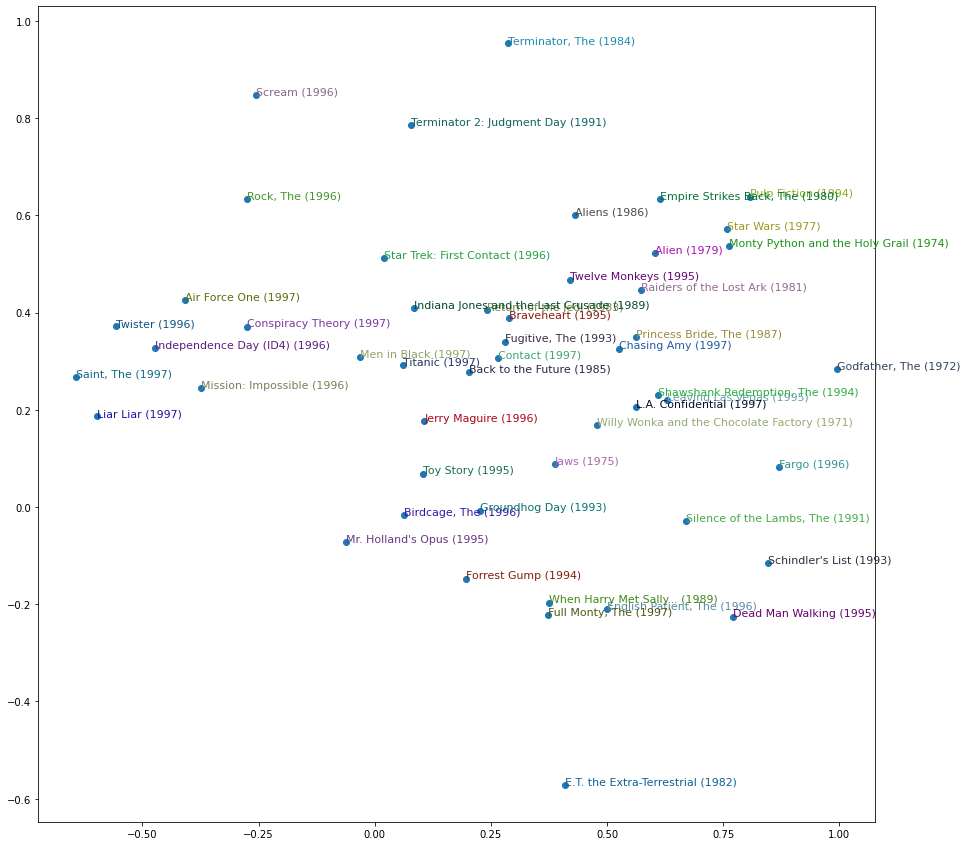

In [52]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()